In [16]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools


In [17]:
# Load the dataset
df = pd.read_csv('dataset_mp.csv')

# Display the first 5 rows
df.head()


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [18]:
# Check for missing values
df.isnull().sum()


Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [19]:
# Drop any rows with missing values
df = df.dropna()

# Check new shape
df.shape


(1986, 27)

In [20]:
# Combine all Top1 to Top25 into one single text column
df['combined_text'] = df[['Top'+str(i) for i in range(1,26)]].apply(lambda x: ' '.join(x), axis=1)

# Display first few combined texts
df['combined_text'].head()


0    b"Georgia 'downs two Russian warplanes' as cou...
1    b'Why wont America and Nato help us? If they w...
2    b'Remember that adorable 9-year-old who sang a...
3    b' U.S. refuses Israel weapons to attack Iran:...
4    b'All the experts admit that we should legalis...
Name: combined_text, dtype: object

In [21]:
# Tokenization parameters
VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100

# Create and fit the tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df['combined_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['combined_text'])

# Pad sequences to the same length
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Check shape
padded_sequences.shape


(1986, 300)

In [22]:
# Target labels
y = df['Label']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42
)

# Check shapes
X_train.shape, X_test.shape


((1588, 300), (398, 300))

## BiLSTM Model


In [27]:
from tensorflow.keras.layers import Dropout  # New import for Dropout

# Build the Improved Deep Learning model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_shape=(MAX_SEQUENCE_LENGTH,)))

# 1st BiLSTM Layer + Dropout
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))

# 2nd BiLSTM Layer + Dropout
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))

# Dense Layer
model.add(Dense(256, activation='relu'))

# Output Layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 300, 100)       │       500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 300, 512)       │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953,926 (7.45 MB)

 Trainable params: 1,953,926 (7.45 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,   # Increased to 10
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 681ms/step - accuracy: 0.5123 - loss: 0.6932 - val_accuracy: 0.5276 - val_loss: 0.6914
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 711ms/step - accuracy: 0.5933 - loss: 0.6749 - val_accuracy: 0.4749 - val_loss: 0.7296
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 861ms/step - accuracy: 0.8371 - loss: 0.4615 - val_accuracy: 0.5226 - val_loss: 1.0486
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 857ms/step - accuracy: 0.9833 - loss: 0.0693 - val_accuracy: 0.4874 - val_loss: 1.6836
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 855ms/step - accuracy: 0.9983 - loss: 0.0115 - val_accuracy: 0.5075 - val_loss: 2.1983
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - accuracy: 0.9996 - loss: 0.0037 - val_accuracy: 0.5025 - val_loss: 2.5559
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 864ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.5101 - val_loss: 2.5298
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accu

In [29]:
# Predict on test set
test_pred = model.predict(X_test)

# Convert predicted probabilities to class labels (0 or 1)
test_pred_labels = np.argmax(test_pred, axis=1)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test, test_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step
Test Accuracy: 0.5151


In [40]:
# Helper function to plot confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step
Test Accuracy: 0.5151
Precision: 0.5479
Recall: 0.4882
F1 Score: 0.5163

Classification Report:

              precision    recall  f1-score   support

        Down       0.49      0.55      0.51       187
          Up       0.55      0.49      0.52       211

    accuracy                           0.52       398
   macro avg       0.52      0.52      0.52       398
weighted avg       0.52      0.52      0.52       398



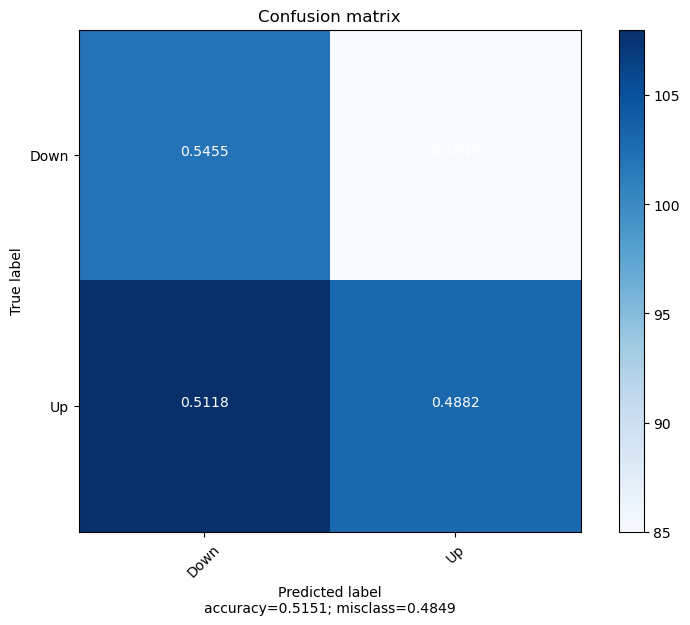

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predict again (already predicted but keeping clean)
test_pred = model.predict(X_test)
test_pred_labels = np.argmax(test_pred, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_test, test_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Precision
precision = precision_score(y_test, test_pred_labels)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, test_pred_labels)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, test_pred_labels)
print(f"F1 Score: {f1:.4f}")

# Full classification report
print("\nClassification Report:\n")
print(classification_report(y_test, test_pred_labels, target_names=['Down', 'Up']))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred_labels)

# Plot Confusion Matrix
plot_confusion_matrix(cm, target_names=['Down', 'Up'])


## CNN Model (1D Convolution)


In [33]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# Build the CNN model
cnn_model = Sequential()

# Embedding layer (same as before)
cnn_model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_shape=(MAX_SEQUENCE_LENGTH,)))

# 1D Convolutional layer
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Global Max Pooling
cnn_model.add(GlobalMaxPooling1D())

# Dense Layer
cnn_model.add(Dense(256, activation='relu'))

# Output Layer
cnn_model.add(Dense(2, activation='softmax'))

# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
cnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 300, 100)       │       500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,766 (2.28 MB)

 Trainable params: 597,766 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the CNN model
cnn_history = cnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5139 - loss: 0.6953 - val_accuracy: 0.5226 - val_loss: 0.6926
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7784 - loss: 0.6549 - val_accuracy: 0.4573 - val_loss: 0.7045
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9411 - loss: 0.4352 - val_accuracy: 0.4724 - val_loss: 0.7234
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0441 - val_accuracy: 0.5176 - val_loss: 0.7521
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.5126 - val_loss: 0.7696
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.5226 - val_loss: 0.7725
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.5176 - val_loss: 0.7841
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.9941e-04 - val_accuracy: 0.5176

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
CNN Test Accuracy: 0.5251
CNN Precision: 0.5390
CNN Recall: 0.7204
CNN F1 Score: 0.6166

CNN Classification Report:

              precision    recall  f1-score   support

        Down       0.49      0.30      0.38       187
          Up       0.54      0.72      0.62       211

    accuracy                           0.53       398
   macro avg       0.52      0.51      0.50       398
weighted avg       0.52      0.53      0.50       398



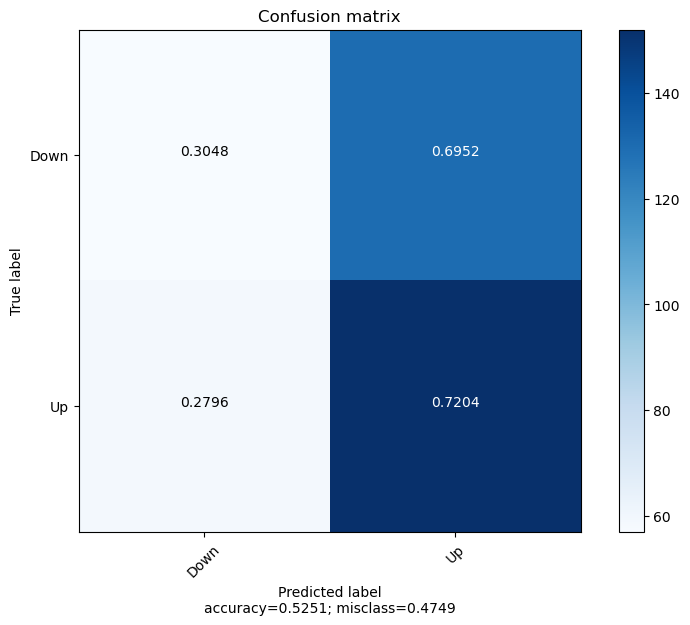

In [35]:
# Predict on test set
cnn_test_pred = cnn_model.predict(X_test)

# Convert probabilities to class labels
cnn_test_pred_labels = np.argmax(cnn_test_pred, axis=1)

# Evaluate Accuracy
cnn_test_accuracy = accuracy_score(y_test, cnn_test_pred_labels)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# Precision
cnn_precision = precision_score(y_test, cnn_test_pred_labels)
print(f"CNN Precision: {cnn_precision:.4f}")

# Recall
cnn_recall = recall_score(y_test, cnn_test_pred_labels)
print(f"CNN Recall: {cnn_recall:.4f}")

# F1 Score
cnn_f1 = f1_score(y_test, cnn_test_pred_labels)
print(f"CNN F1 Score: {cnn_f1:.4f}")

# Full classification report
print("\nCNN Classification Report:\n")
print(classification_report(y_test, cnn_test_pred_labels, target_names=['Down', 'Up']))

# Confusion Matrix
cnn_cm = confusion_matrix(y_test, cnn_test_pred_labels)

# Plot Confusion Matrix
plot_confusion_matrix(cnn_cm, target_names=['Down', 'Up'])


## BiGRU Model


In [36]:
from tensorflow.keras.layers import GRU

# Build the BiGRU model
bigru_model = Sequential()

# Embedding layer (same as before)
bigru_model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_shape=(MAX_SEQUENCE_LENGTH,)))

# 1st Bidirectional GRU layer + Dropout
bigru_model.add(Bidirectional(GRU(256, return_sequences=True)))
bigru_model.add(Dropout(0.5))

# 2nd Bidirectional GRU layer + Dropout
bigru_model.add(Bidirectional(GRU(128, return_sequences=False)))
bigru_model.add(Dropout(0.5))

# Dense layer
bigru_model.add(Dense(256, activation='relu'))

# Output layer
bigru_model.add(Dense(2, activation='softmax'))

# Compile the model
bigru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
bigru_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 300, 100)       │       500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 300, 512)       │       549,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,609,350 (6.14 MB)

 Trainable params: 1,609,350 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train the BiGRU model
bigru_history = bigru_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 631ms/step - accuracy: 0.5152 - loss: 0.6950 - val_accuracy: 0.5302 - val_loss: 0.6903
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 737ms/step - accuracy: 0.5740 - loss: 0.6694 - val_accuracy: 0.5000 - val_loss: 0.7341
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - accuracy: 0.8857 - loss: 0.3335 - val_accuracy: 0.4975 - val_loss: 1.1377
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 855ms/step - accuracy: 0.9896 - loss: 0.0541 - val_accuracy: 0.5025 - val_loss: 2.0597
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 856ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.5050 - val_loss: 2.4521
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 858ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.5226 - val_loss: 2.8539
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 841ms/step - accuracy: 1.0000 - loss: 5.4389e-04 - val_accuracy: 0.5276 - val_loss: 3.0618
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 770ms/step - accuracy: 1.0000 - loss: 2.3091e-04 - 

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
BiGRU Test Accuracy: 0.5327
BiGRU Precision: 0.5676
BiGRU Recall: 0.4976
BiGRU F1 Score: 0.5303

BiGRU Classification Report:

              precision    recall  f1-score   support

        Down       0.50      0.57      0.53       187
          Up       0.57      0.50      0.53       211

    accuracy                           0.53       398
   macro avg       0.53      0.53      0.53       398
weighted avg       0.54      0.53      0.53       398



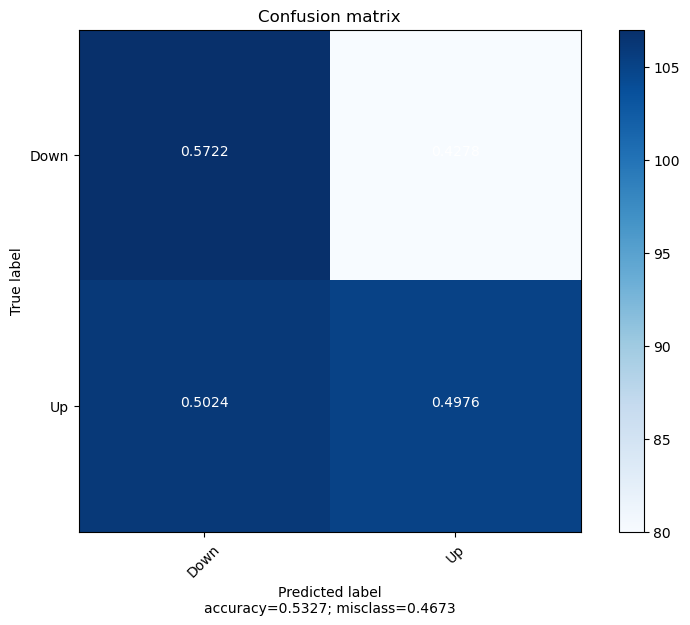

In [39]:
# Predict on test set
bigru_test_pred = bigru_model.predict(X_test)

# Convert probabilities to class labels
bigru_test_pred_labels = np.argmax(bigru_test_pred, axis=1)

# Evaluate Accuracy
bigru_test_accuracy = accuracy_score(y_test, bigru_test_pred_labels)
print(f"BiGRU Test Accuracy: {bigru_test_accuracy:.4f}")

# Precision
bigru_precision = precision_score(y_test, bigru_test_pred_labels)
print(f"BiGRU Precision: {bigru_precision:.4f}")

# Recall
bigru_recall = recall_score(y_test, bigru_test_pred_labels)
print(f"BiGRU Recall: {bigru_recall:.4f}")

# F1 Score
bigru_f1 = f1_score(y_test, bigru_test_pred_labels)
print(f"BiGRU F1 Score: {bigru_f1:.4f}")

# Full classification report
print("\nBiGRU Classification Report:\n")
print(classification_report(y_test, bigru_test_pred_labels, target_names=['Down', 'Up']))

# Confusion Matrix
bigru_cm = confusion_matrix(y_test, bigru_test_pred_labels)

# Plot Confusion Matrix
plot_confusion_matrix(bigru_cm, target_names=['Down', 'Up'])


## Final Model Comparison

| Model | Test Accuracy | Precision | Recall | F1 Score |
|:------|:--------------|:----------|:-------|:---------|
| BiLSTM | 0.5151 | 0.5479 | 0.4882 | 0.5163 |
| CNN (Conv1D) | 0.5251 | 0.5390 | 0.7204 | 0.6166 |
| BiGRU | 0.5327 | 0.5676 | 0.4976 | 0.5303 |

**Observations:**
- CNN achieved the highest Recall and F1-Score, making it good at detecting the "Up" class.
- BiGRU achieved the highest overall Test Accuracy (53.27%) and a balanced Precision and F1-Score.
- BiLSTM performed decently but was slightly weaker compared to CNN and BiGRU on this dataset.
- Different deep learning architectures behave differently even when trained on the same data, highlighting the importance of model exploration.
